Author: ttsiapras\
Disparity extraction Methods

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider
import ipywidgets as widgets

## Example with a known sample from https://vision.middlebury.edu/stereo/data/

In [15]:
R1 = r"C:\Users\user1\Desktop\StereoB2.png"
R2 = r"C:\Users\user1\Desktop\SteroB3.png"
L0 = r"C:\Users\user1\Desktop\StereoB1.png"
# "C:\Users\user1\Desktop\SteroB3.png"
# "C:\Users\user1\Desktop\StereoB1.png"
# "C:\Users\user1\Desktop\StereoB2.png"
imageL = cv.imread(L0,0)
imageR = cv.imread(R2,0)


r = cv.selectROI("select the area", imageL)
cv.destroyAllWindows()


**These datasets of piecewise planar scenes were created by Daniel Scharstein, Padma Ugbabe, and Rick Szeliski. Each set contains 9 images (im0.ppm - im8.ppm) and ground-truth disparity maps for images 2 and 6 (disp2.pgm and disp6.pgm). Each ground-truth disparity map is scaled by a factor of 8. For example, a value of 100 in disp2.pgm means that the corresponding pixel in im6.ppm is 12.5 pixels to the left**

## Stereo SGBM

In [9]:
disparity_SGBM = []
disparity_SGBM_vis = []

def SGBM(block_size,max_disp,uniquenessRatio,speckleWindowSize,speckleRange,disp12MaxDiff=0):
    global disparity_SGBM
    global disparity_SGBM_vis
    # Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
    #block_size = 4

    min_disp = -max_disp
    #max_disp = -min_disp
    # Maximum disparity minus minimum disparity. The value is always greater than zero.
    # In the current implementation, this parameter must be divisible by 16.
    num_disp = max_disp - min_disp

    # Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
    # Normally, a value within the 5-15 range is good enough
    #uniquenessRatio = 5

    # Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
    # Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
    #speckleWindowSize = 50

    # Maximum disparity variation within each connected component.
    # If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
    # Normally, 1 or 2 is good enough.
    #speckleRange = 3
    #disp12MaxDiff = 0

    stereo = cv.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=block_size,
        uniquenessRatio=uniquenessRatio,
        speckleWindowSize=speckleWindowSize,
        speckleRange=speckleRange,
        disp12MaxDiff=disp12MaxDiff,
        P1=8 * 1 * block_size * block_size,
        P2=32 * 1 * block_size * block_size,
        mode=cv.STEREO_SGBM_MODE_SGBM_3WAY
    )
    disparity_SGBM = stereo.compute(imageL,imageR)

    # Normalize the values to a range from 0..255 for a grayscale image
    disparity_SGBM_vis = cv.normalize(np.copy(disparity_SGBM), np.copy(disparity_SGBM), alpha=255,
                                  beta=0, norm_type=cv.NORM_MINMAX)
    disparity_SGBM_vis = np.uint8(disparity_SGBM_vis)
    
    #minDisp = disparity_SGBM.mean()-disparity_SGBM.std()
    plt.figure(figsize=(20,16))
    plt.imshow(disparity_SGBM_vis,cmap="gray")
    plt.axis('off')
    plt.show()
    #print(disparity_SGBM.shape)
    #print(int(disparity_SGBM[s_pt[0]:e_pt[0],s_pt[1]:e_pt[1]].mean())/16)
    #cv.imwrite("disparity_SGBM_norm.png", disparity_SGBM)
    return()

In [16]:
#imageL = images[2]
#imageR = images[6]
#import ipywidgets as widgets
%matplotlib inline
interact(SGBM, block_size=(1,21,2), max_disp=(16,64,16),uniquenessRatio=(1,20,1),speckleWindowSize=(20,200,10),speckleRange=(1,10,1),disp12MaxDiff=(0,100,1));


interactive(children=(IntSlider(value=11, description='block_size', max=21, min=1, step=2), IntSlider(value=32…

## Stereo BM

In [11]:
BM_disparity = []
def BM(numDisparities=16,blocksize=5,uniquenessRatio=1):
    global BM_disparity
    stereo = cv.StereoBM_create(numDisparities=numDisparities, blockSize=blocksize)
    stereo.setUniquenessRatio(uniquenessRatio)
    
    BM_disparity = stereo.compute(imageL,imageR)
    plt.figure(figsize=(20,16))
    plt.imshow(BM_disparity,cmap="gray")
    plt.axis('off')
    plt.show()
    return()

In [17]:
interact(BM,numDisparities=(16,160,16), blocksize=(5,100,2),uniquenessRatio=(1,20,1))

interactive(children=(IntSlider(value=16, description='numDisparities', max=160, min=16, step=16), IntSlider(v…

<function __main__.BM(numDisparities=16, blocksize=5, uniquenessRatio=1)>

### STEREO SGBM with postprocessing

In [13]:
SGBMp_raw = []
SGBMp_vis = []
def SGBM_plus(block_size,
         max_disp,
         uniquenessRatio,
         speckleWindowSize,
         speckleRange,
         disp12MaxDiff=0,
         l=80000,sigma=1.2,vis_mul=1.0):
    global SGBMp_raw,SGBMp_vis
    # Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
    #block_size = 4

    min_disp = -max_disp
    #max_disp = -min_disp
    # Maximum disparity minus minimum disparity. The value is always greater than zero.
    # In the current implementation, this parameter must be divisible by 16.
    num_disp = max_disp - min_disp

    # Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
    # Normally, a value within the 5-15 range is good enough
    #uniquenessRatio = 5

    # Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
    # Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
    #speckleWindowSize = 50

    # Maximum disparity variation within each connected component.
    # If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
    # Normally, 1 or 2 is good enough.
    #speckleRange = 3
    #disp12MaxDiff = 0

    left_matcher = cv.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=block_size,
        uniquenessRatio=uniquenessRatio,
        speckleWindowSize=speckleWindowSize,
        speckleRange=speckleRange,
        disp12MaxDiff=disp12MaxDiff,
        P1=8 * 1 * block_size * block_size,
        P2=32 * 1 * block_size * block_size,
    )
    right_matcher = cv.ximgproc.createRightMatcher(left_matcher)
    
    # FILTER Parameters
    lmbda = l
    sigma = sigma
    visual_multiplier = vis_mul
 
    wls_filter = cv.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)
    
    displ = left_matcher.compute(imageL, imageR)  # .astype(np.float32)/16
    dispr = right_matcher.compute(imageR, imageL)

    print(displ.min(),displ.max())
    displ = np.int16(displ)
    dispr = np.int16(dispr)
    print(displ.min(),displ.max())
    
    SGBMp_raw = wls_filter.filter(displ, imageL, None, dispr)
    data = SGBMp_raw.flatten()
    temp = data[abs(data - np.mean(data)) < 4 * np.std(data)]
    low = temp.min()
    high= temp.max()
    SGBMp_raw = np.clip(SGBMp_raw,low,high)
    #plt.figure(figsize=(20,16)); plt.imshow(SGBMp_raw,cmap="inferno")

    SGBMp_vis = np.copy(SGBMp_raw)
    SGBMp_vis = cv.normalize(src=SGBMp_vis, dst=SGBMp_vis, beta=0,alpha=255, norm_type=cv.NORM_MINMAX);
    SGBMp_vis = np.uint8(SGBMp_vis)
    # Normalize the values to a range from 0..255 for a grayscale image
    plt.figure(figsize=(20,16))
    plt.imshow(SGBMp_vis,cmap="inferno")
    plt.show()
    return(1)

In [18]:
%matplotlib inline
interact(SGBM_plus, block_size=(1,11,2), max_disp=(16,128,16), uniquenessRatio=(1,20,1), speckleWindowSize=(20,200,10),speckleRange=(1,10,1),disp12MaxDiff=(0,100,1),l=(80000-10000,80000+10000,1000),sigma=(0.5,1.5,0.1),vis_mul=(0.1,2,0.1));

interactive(children=(IntSlider(value=5, description='block_size', max=11, min=1, step=2), IntSlider(value=64,…

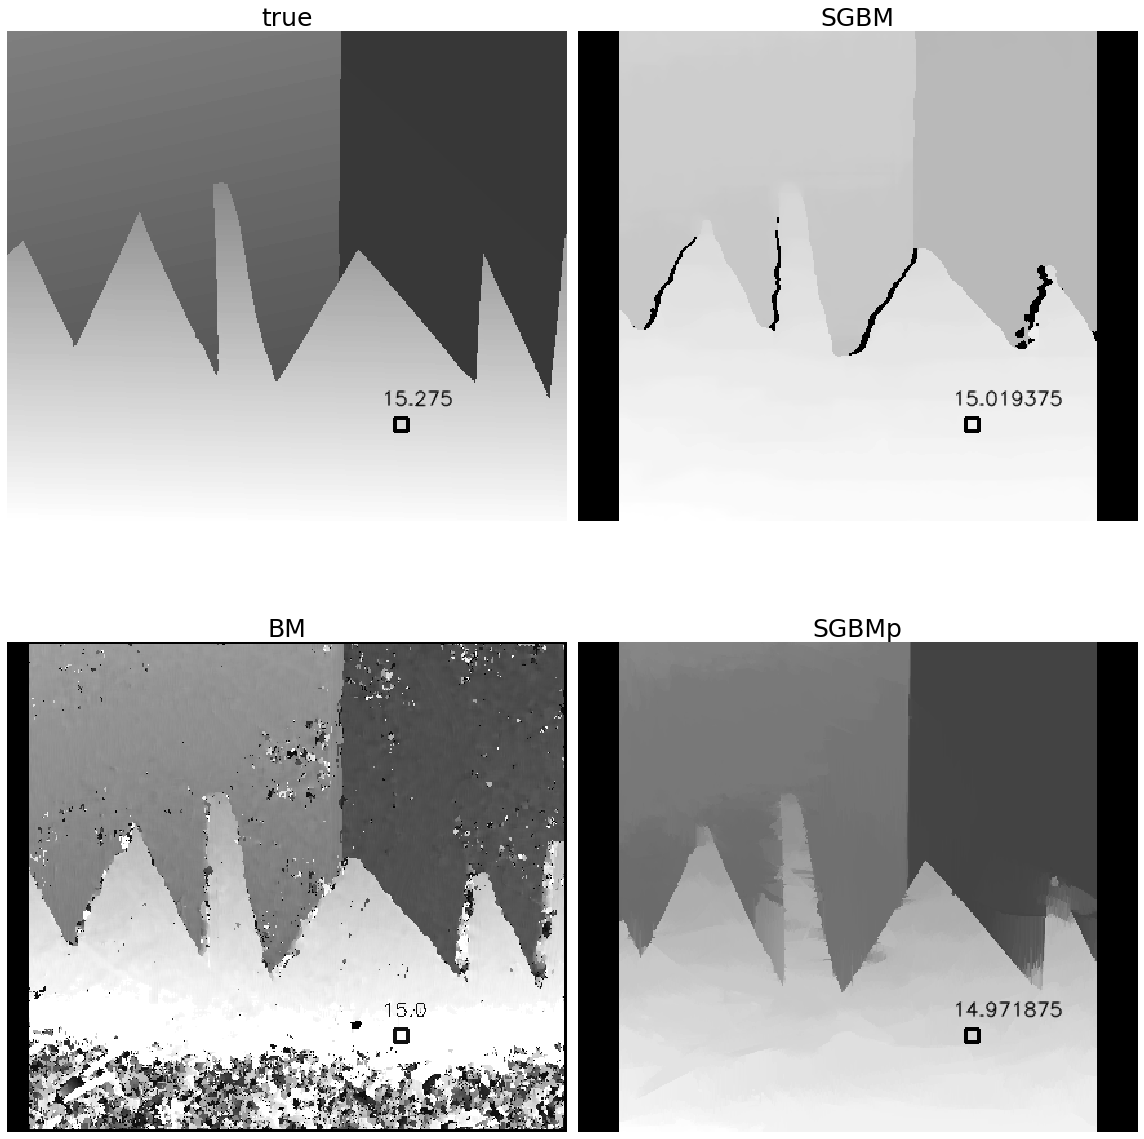

In [11]:
with_rect = cv.rectangle(np.copy(disparity_SGBM_vis),s_pt,e_pt,(0,0,0),2)
roi_disp = disparity_SGBM[s_pt[1]:e_pt[1],s_pt[0]:e_pt[0]].mean()/16
with_rect_SGBM = cv.putText(with_rect, str(roi_disp),t_pt,
                            cv.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1,cv.LINE_AA)
with_rect = cv.rectangle(np.copy(BM_disparity),s_pt,e_pt,(0,0,0),2)
roi_disp = BM_disparity[s_pt[1]:e_pt[1],s_pt[0]:e_pt[0]].mean()/16
with_rect_BM = cv.putText(with_rect, str(roi_disp), t_pt, 
                       cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv.LINE_AA)
with_rect = cv.rectangle(np.copy(SGBMp_vis),s_pt,e_pt,(0,0,0),2)
roi_disp = SGBMp_raw[s_pt[1]:e_pt[1],s_pt[0]:e_pt[0]].mean()/16
with_rect_SGBMp = cv.putText(with_rect, str(roi_disp), t_pt, 
                       cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv.LINE_AA)

fig = plt.figure(figsize=(16,18))
fig.add_subplot(2,2,1)
plt.imshow(with_rect_true,cmap='gray'); plt.axis('off'); plt.title("true",fontsize=25)
fig.add_subplot(2,2,2)
plt.imshow(with_rect_SGBM,cmap='gray'); plt.axis('off'); plt.title("SGBM",fontsize=25)
fig.add_subplot(2,2,3)
plt.imshow(with_rect_BM,cmap='gray'); plt.axis('off'); plt.title("BM",fontsize=25)
fig.add_subplot(2,2,4)
plt.imshow(with_rect_SGBMp,cmap='gray'); plt.axis('off'); plt.title("SGBMp",fontsize=25)

plt.tight_layout()